# Titanic

This notebook is an example on how to work with the VerticaPy Module. We will use the Titanic dataset to introduce the library. The purpose is to predict the passengers survival. You can download the Jupyter Notebook of the study by clicking <a href="titanic.ipynb">here</a>.

## Initialization

To avoid redundant cursors creation, let's create an auto connection.

In [1]:
from verticapy.connections.connect import *
new_auto_connection({"host": "10.211.55.14", 
                     "port": "5433", 
                     "database": "testdb", 
                     "password": "XxX", 
                     "user": "dbadmin"}, 
                    method = "vertica_python", 
                    name = "VML")
change_auto_connection("VML")

Use the following command to allow Matplotlib to display graphic.

In [2]:
%matplotlib inline

Let's load the Titanic dataset.

In [3]:
from verticapy.learn.datasets import load_titanic
titanic = load_titanic()
print(titanic)

<object>  Name: titanic, Number of rows: 1234, Number of columns: 14


## Data Exploration and Preparation

Let's explore the data by displaying descriptive statistics of all the columns.

In [4]:
titanic.describe(method = "categorical")

<object>

The column "body" is useless (it is only the ID of the passengers).
The column "home.dest" will not influence the survival, it is just from where the passengers embarked and where they are going to. We can have the same conclusion with "embarked" which is the port of embarkation. The column 'ticket' which is the ticket ID will also not give us information on the survival. 

Let's analyze the columns "name" and "cabin to see if we can extract some information. Let's first look at the passengers names.

In [5]:
from verticapy.learn.preprocessing import CountVectorizer
CountVectorizer("name_voc").fit("titanic", ["Name"]).to_vdf()

<object>  Name: name_voc, Number of rows: 1841, Number of columns: 4

From the "name" it is possible to extract the title of the passengers. Let's now look at the "cabins".

In [6]:
from verticapy.learn.preprocessing import CountVectorizer
CountVectorizer("cabin_voc").fit("titanic", ["cabin"]).to_vdf()

<object>  Name: cabin_voc, Number of rows: 199, Number of columns: 4

We can extract the cabin position (the letter which reprent the position in the boat) and look at the number of occurences.

In [7]:
CountVectorizer("cabin_voc").fit("titanic", ["cabin"]).to_vdf(
                )["token"].str_slice(1, 1).groupby(
                columns = ["token"], expr = ["SUM(cnt)"]).head(30)

<object>  Name: groupby, Number of rows: 9, Number of columns: 2

The NULL values possibly represent passengers having no cabin (MNAR = Missing values not at random). The same for the column "boat" where NULL values represent passengers who have a dedicated "lifeboat". We can drop the useless columns and encode the others.

In [8]:
titanic.drop(["body", "home.dest", "embarked", "ticket"])

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

In [9]:
titanic["cabin"].str_slice(1, 1)["name"].str_extract(
        ' ([A-Za-z]+)\.')["boat"].fillna(
        method = "0ifnull")["cabin"].fillna("No Cabin")

795 element(s) was/were filled
948 element(s) was/were filled


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

We can notice that our assumptions about the cabin are wrong as the first class passengers should have a cabin. This column has missing values at random (MAR) and too much. Let's drop it.

In [10]:
titanic["cabin"].drop()

<object>  Name: titanic, Number of rows: 1234, Number of columns: 9

Let's look at descriptive statistics of the entire Virtual Dataframe.

In [11]:
titanic.statistics()

<object>

This method will help us to understand a bit more our data. For example, we can notice that the "age" of the passengers follows more or less a normal distribution (kurtosis and skewness around 0). Let's draw the "age" histogram to verify our hypothesis.

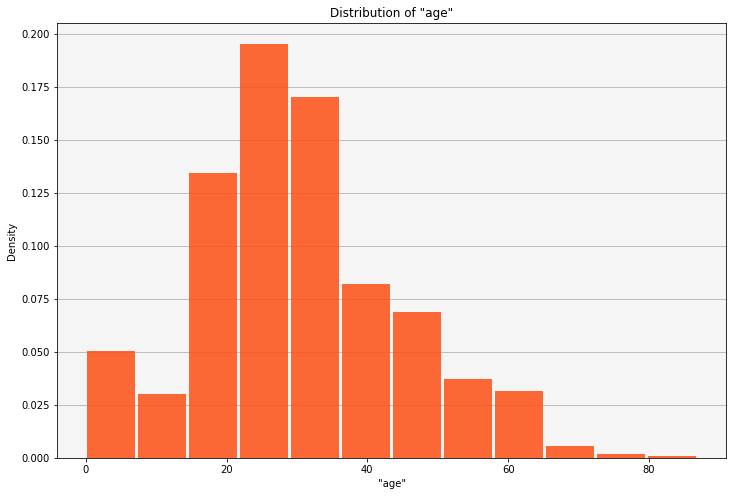

In [12]:
x = titanic["age"].hist()

We can also do a Jarque Bera test to prove our hypothesis.

In [13]:
x.testjb("age")

We test the following hypothesis:
(H0) The distribution of "age" is not normal
(H1) The distribution of "age" is normal
👍 - The distribution of "age" might be normal
jb = 28.5338631758186
p_value = 0.0


(True, 28.5338631758186, 0.0)

Many other relevant information can be noticed. The column 'fare' has many outliers (The maximum 512.33 is much greater than the 9th decile 79.13). Most of the passengers traveled in 3rd class (median of pclass = 3) and much more...

As 'sibsp' represents the number of siblings and parch the number of parents and children, it can be relevant to create a new feature: 'family_size'.

In [14]:
titanic.eval("family_size", "parch + sibsp + 1")

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

Let's deal with the outliers. There are many methods to find them (LocalOutlier Factor, DBSCAN, KMeans...) but we will just winsorize the 'fare' distribution which is subject to huge anomalies. 

In [15]:
titanic["fare"].fill_outliers(method = "winsorize", alpha = 0.03)

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

Let's encode the column 'sex' to be able to use it with numerical methods. 

In [16]:
titanic["sex"].label_encode()

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

The column 'age' has too many missing values and as most of the ML algorithms do not handle them, we need to use imputation techniques. Let's fill the missing values using the average 'age' of the passengers having the same 'pclass' and the same 'sex'.

In [17]:
titanic["age"].fillna(method = "mean", by = ["pclass", "sex"])

237 element(s) was/were filled


<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

Let's draw the correlation matrix to see the variables links.

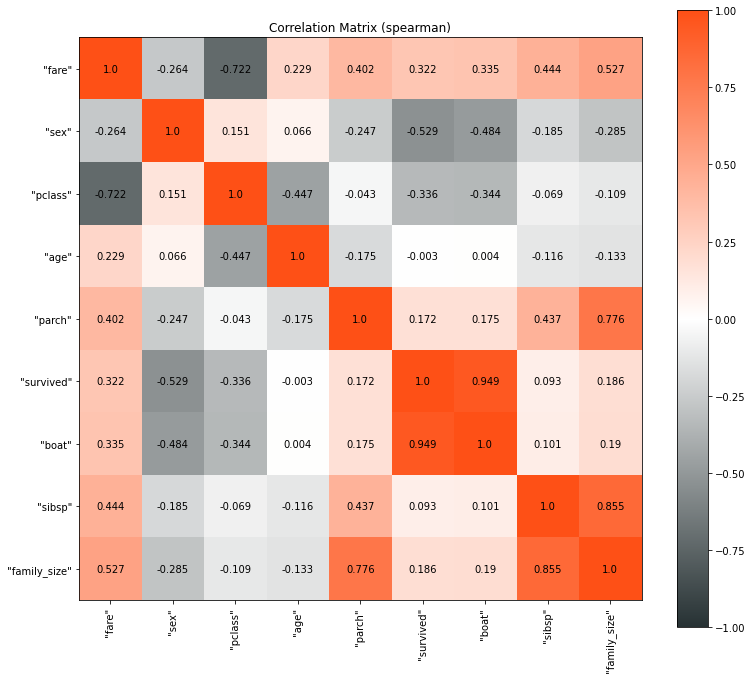

<object>

In [18]:
titanic.corr(method = "spearman")

The fare is very correlated to the family size. It is normal as the bigger the family is, the greater the number of tickets they have to buy will be (so the 'fare' as well). The survival is very correlated to the 'boat' variable. To avoid predictions only based on one variable and to increase the generality, we must split the study into 2 use cases.
<ul>
    <li>Passengers having no lifeboat</li>
    <li>Passengers having a lifeboat</li>
</ul>
We did a lot of operations to clean this data and nothing was saved in the DB ! We can look at the Virtual Dataframe relation to be sure.

In [19]:
print(titanic.current_relation())

(
   SELECT
     "fare",
     "sex",
     "pclass",
     COALESCE("age", AVG("age") OVER (PARTITION BY "pclass", "sex")) AS "age",
     "name",
     "parch",
     "survived",
     "boat",
     "sibsp",
     "family_size" 
   FROM
 (
   SELECT
     (CASE WHEN "fare" < -176.6204982585513 THEN -176.6204982585513 WHEN "fare" > 244.5480856064831 THEN 244.5480856064831 ELSE "fare" END) AS "fare",
     DECODE("sex", 'female', 0, 'male', 1, 2) AS "sex",
     "pclass",
     "age",
     REGEXP_SUBSTR("name", ' ([A-Za-z]+)\.') AS "name",
     "parch",
     "survived",
     DECODE("boat", NULL, 0, 1) AS "boat",
     "sibsp",
     parch + sibsp + 1 AS "family_size" 
   FROM
 (
   SELECT
     "fare",
     "sex",
     "pclass",
     "age",
     "name",
     "parch",
     "survived",
     "boat",
     "sibsp" 
   FROM
 "public"."titanic") 
VERTICAPY_SUBTABLE) 
VERTICAPY_SUBTABLE) 
VERTICAPY_SUBTABLE


Let see what's happening when we aggregate and turn on the SQL.

In [20]:
titanic.sql_on_off().avg()

<object>

VerticaPy will do SQL code generation during the entire process and it will keep in mind all the users modifications. Besides, it will store already computed aggregations to not compute them twice. The catalog will be updated in case of filtering or modifications which will affect the concern columns.

In [21]:
titanic.sql_on_off().info()

The vDataFrame was modified many times: 
 * {Tue Jun 30 01:53:19 2020} [Drop]: vcolumn "body" was deleted from the vDataFrame.
 * {Tue Jun 30 01:53:19 2020} [Drop]: vcolumn "home.dest" was deleted from the vDataFrame.
 * {Tue Jun 30 01:53:19 2020} [Drop]: vcolumn "embarked" was deleted from the vDataFrame.
 * {Tue Jun 30 01:53:19 2020} [Drop]: vcolumn "ticket" was deleted from the vDataFrame.
 * {Tue Jun 30 01:53:19 2020} [SUBSTR(, 1, 1)]: The vcolumn 'cabin' was transformed with the func 'x -> SUBSTR(x, 1, 1)'.
 * {Tue Jun 30 01:53:19 2020} [REGEXP_SUBSTR(, ' ([A-Za-z]+)\.')]: The vcolumn 'name' was transformed with the func 'x -> REGEXP_SUBSTR(x, ' ([A-Za-z]+)\.')'.
 * {Tue Jun 30 01:53:19 2020} [Fillna]: 795.0 missing value(s) of the vcolumn "boat" was/were filled.
 * {Tue Jun 30 01:53:19 2020} [Fillna]: 948.0 missing value(s) of the vcolumn "cabin" was/were filled.
 * {Tue Jun 30 01:53:19 2020} [Drop]: vcolumn "cabin" was deleted from the vDataFrame.
 * {Tue Jun 30 01:53:21 2020} [

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10

You already love the Virtual Dataframe, do you? &#128540;

If you want to share the object with a member of the team, you can use the following method.

In [22]:
x = titanic.to_vdf("titanic")

We created a .vdf file which can be read with the 'read_vdf' function:

In [23]:
from verticapy.utilities import read_vdf
titanic2 = read_vdf("titanic.vdf")
print(titanic2)

<object>  Name: titanic, Number of rows: 1234, Number of columns: 10


Let's now save the vDataframe in the Database to fulfill the next step: Data Modelling.

In [24]:
from verticapy import drop_view
drop_view("titanic_boat")
drop_view("titanic_no_boat")
x = titanic.save().filter("boat = 1").to_db("titanic_boat").load(
                 ).filter("boat = 0").to_db("titanic_no_boat")

The view titanic_boat was successfully dropped.
The view titanic_no_boat was successfully dropped.
795 element(s) was/were filtered
439 element(s) was/were filtered


## Machine Learning

### Passengers with a lifeboat


First let's look at the number of survivors in this dataset.

In [26]:
from verticapy import vDataFrame
titanic_boat = vDataFrame("titanic_boat")
titanic_boat["survived"].describe()

<object>

We only have 9 death. Let's try to understand why these passengers died.

In [27]:
titanic_boat.filter("survived = 0").head(10)

430 element(s) was/were filtered


<object>  Name: titanic_boat, Number of rows: 9, Number of columns: 10

These passengers have no reason to die except the ones in third class. Building a model for this part of the data is useless.

### Passengers without a lifeboat

Let's now look at passengers without a lifeboat. 

In [29]:
titanic_boat = vDataFrame("titanic_no_boat")
titanic_boat["survived"].describe()

<object>

Only 20 survived. Let's look why.

In [30]:
titanic_boat.filter("survived = 1").head(20)

775 element(s) was/were filtered


<object>  Name: titanic_no_boat, Number of rows: 20, Number of columns: 10

They are mostly women. The famous quotation "Women and children first" is then right. Let's build a model to get more insights. 

One of our predictor is categorical (the passenger title). Besides, some of the predictors are correlated. It is preferable to work with a non-linear classifier which can handle that. Random Forest seems to be perfect for the study. Let's evaluate it with a Cross Validation.

In [33]:
from verticapy.learn.ensemble import RandomForestClassifier
from verticapy.learn.model_selection import cross_validate

predictors = titanic.get_columns(exclude_columns = ['"survived"'])
response = "survived"
relation = "titanic_no_boat"
model = RandomForestClassifier("rf_titanic", 
                               n_estimators = 40, 
                               max_depth = 4)
cross_validate(model, relation, predictors, response)

<object>

As the dataset is unbalanced, the AUC is a good way to evaluate it. <br>
The model is very good with an average greater than 0.9 ! <br>
We can now build a model with the entire dataset.

In [34]:
model.fit(relation, predictors, response)



call_string
SELECT rf_classifier('public.rf_titanic', 'titanic_no_boat', '"survived"', '"fare", "sex", "pclass", "age", "name", "parch", "boat", "sibsp", "family_size"' USING PARAMETERS exclude_columns='', ntree=40, mtry=4, sampling_size=0.632, max_depth=4, max_breadth=1000000000, min_leaf_size=1, min_info_gain=0, nbins=32);

details
 predictor |      type      
-----------+----------------
   fare    |float or numeric
    sex    |      int       
  pclass   |      int       
    age    |float or numeric
   name    |char or varchar 
   parch   |      int       
   boat    |      int       
   sibsp   |      int       
family_size|      int       


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 40  
rejected_row_count|  1  
accepted_row_count| 794 

Let's look at the features importance.

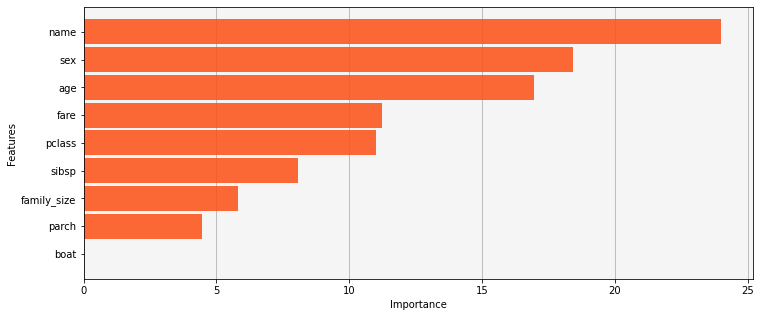

<object>

In [35]:
model.features_importance()

As expected, the title and the sex are the most important predictors.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.